In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path
from scipy.special import rel_entr, kl_div
from scipy.stats import wasserstein_distance
import h5py

plt.rcParams.update({'font.size': 13}) 

which_changes = ["bootstrapped_data", "model_init", "hmc_init"] 
PARAMETERS = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr'] 
which_changes_short = ["Data", "Model", "HMC"]
PARAMETERS_NAME = [r'$k^{0}_{\parallel}$', r'$a_{\parallel}$', r'$a_{\perp}$', r'$b_{\parallel}$', r'$b_{\perp}$'] 
PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 

# Hardcoded model choices.
INPUTS = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
# These are hardcoded for transforms. Used in both parities.
X_MIN = np.array([0.,  2.5, 100., 0.4, 0.4, 0.4, 0.4, 400.]) 
X_MAX = np.array([85., 9.5, 870., 1.7, 1.7, 2.3, 2.3, 700.])
X_RANGE = np.array([ 85., 7., 770., 1.3000001, 1.3000001, 1.9, 1.9, 300.])
# X_MIN,X_MAX,X_RANGE = get_minmax_params(get_attributes(infile))
# These are selected from above and hardcoded.
PARAMETERS = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr'] 
PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 
# These parameter don't include (alpha, cmf, vspoles) which we specify separately.
PARAMETERS_SPECIFIED = ['alpha', 'cmf', 'vspoles']
PARAMETERS_SPECIFIED_MIN = np.array([0.,  2.5, 400.])
PARAMETERS_SPECIFIED_MAX = np.array([85., 9.5, 700.])

## Relevant functions from utils.py
Can't just import utils since path to data is different than utils.py

In [13]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df

def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

def _get_transform_params(X):
    """
    Helper function for calculating min max.
    """
    assert len(PARAMETERS) != len(PARAMETERS_SPECIFIED)
    input_dim = X.ndim
    if (X.ndim == 1 and len(X) == len(INPUTS)) or (X.ndim == 2 and X.shape[1] == len(INPUTS)):
        # Full set of inputs. 
        MIN, MAX = X_MIN, X_MAX
    elif ((X.ndim == 1 and len(X) == len(PARAMETERS)) or (X.ndim == 2 and X.shape[1] == len(PARAMETERS))):
        # Assume specified parameters have already been specified separately.
        MIN, MAX = PARAMETERS_MIN, PARAMETERS_MAX
    elif ((X.ndim == 1 and len(X) == len(PARAMETERS_SPECIFIED)) or (X.ndim == 2 and X.shape[1] == len(PARAMETERS_SPECIFIED))):
        # Assume other parameters have already been specified separately.
        MIN, MAX = PARAMETERS_SPECIFIED_MIN, PARAMETERS_SPECIFIED_MAX
    else:
        raise Exception
    return (MIN, MAX)
    

def transform_input(X):
    '''
    Parameters from HMC are all in min-max scaled space.
    This function tries to smartly handle case where some of the inputs are specified separately.
    '''
    MIN, MAX = _get_transform_params(X)
    RANGE = MAX - MIN
    rval = (X - MIN) / RANGE
    return rval


def untransform_input(X):
    '''
    Parameters from HMC are all in min-max scaled space.
    This function tries to smartly handle case where some of the inputs are specified separately.
    '''
    MIN, MAX = _get_transform_params(X)
    RANGE = MAX - MIN
    rval = X * RANGE + MIN
    return rval

Implement distance metrics, including Gelman-Rubin statistic

In [14]:
def _as_array(x):
    """Get a float64 NumPy array from a pandas Series/array-like."""
    # Works for pandas Series (has .values) and plain np arrays/lists
    try:
        return np.asarray(x.values, dtype=float)
    except AttributeError:
        return np.asarray(x, dtype=float)

def _rhat_from_chains(chains_2d: np.ndarray,
                      ensure_ge1: bool = True,
                      return_details: bool = False):
    """
    Compute Gelman–Rubin R-hat from multiple chains following the 4-step description from 
    https://mystatisticsblog.blogspot.com/2019/04/gelman-rubin-convergence-criteria-for.html. 
    Assumes chains are already prepared (e.g., only second halves if that's your convention), 
    so that `chains_2d` has shape (m, n) with m = #chains and n = samples/chain.

    Steps implemented:
      1) (Warmup removal is assumed done before this function.)
      2) Per-chain mean & variance:  θ̄_j and σ²(θ_j)
      3) Mean-of-means θ̄̄, mean within-chain variance σ̄²(θ),
         variance of chain means σ²(θ̄)
         Then B_j = σ²(θ̄) − (1/n) σ̄²(θ)
      4) R̂ = sqrt( 1 + B_j / σ̄²(θ) )

    Also computes the classic equivalent:
      W = σ̄²(θ), B = n * σ²(θ̄),
      Var⁺ = ((n−1)/n) W + (B/n),
      R̂_classic = sqrt(Var⁺ / W)

    Args
    ----
    chains_2d : np.ndarray
        Shape (m, n): m chains, n samples per chain.
    ensure_ge1 : bool
        If True, clamp R-hat to be at least 1.0 (common practice).
    return_details : bool
        If True, return (rhat, details_dict). Otherwise return rhat (float).

    Returns
    -------
    rhat : float
    (optionally) details : dict with intermediate quantities
    """
    if chains_2d.ndim != 2:
        raise ValueError("chains_2d must have shape (m, n).")
    m, n = chains_2d.shape
    if m < 2 or n < 2:
        out = np.nan
        return (out, {}) if return_details else out

    # Step 2: per-chain means and variances (unbiased)
    theta_bar_j = chains_2d.mean(axis=1)             # θ̄_j
    sigma2_theta_j = chains_2d.var(axis=1, ddof=1)   # σ²(θ_j), unbiased

    # Step 3: across-chain aggregates
    theta_barbar = theta_bar_j.mean()                              # θ̄̄
    sigma2_bar_theta = sigma2_theta_j.mean()                       # σ̄²(θ) = W
    sigma2_theta_bar = theta_bar_j.var(ddof=1)                     # σ²(θ̄)
    B_j = sigma2_theta_bar - (sigma2_bar_theta / n)                # B_j

    # Step 4: scale reduction
    if sigma2_bar_theta <= 0:
        rhat = np.nan
    else:
        rhat = float(np.sqrt(1.0 + (B_j / sigma2_bar_theta)))

    # Optional clamp to ≥ 1
    if ensure_ge1 and np.isfinite(rhat):
        if rhat < 1.0:
            rhat = 1.0

    # Classic form (for verification / curiosity)
    W = sigma2_bar_theta
    B = n * sigma2_theta_bar
    var_plus = ((n - 1) / n) * W + (B / n)
    rhat_classic = float(np.sqrt(var_plus / W)) if W > 0 else np.nan

    if return_details:
        details = {
            "m": m, "n": n,
            "theta_bar_j": theta_bar_j,          # per-chain means
            "sigma2_theta_j": sigma2_theta_j,    # per-chain variances
            "theta_barbar": theta_barbar,        # mean of means
            "sigma2_bar_theta": sigma2_bar_theta,# mean within-chain var (W)
            "sigma2_theta_bar": sigma2_theta_bar,# variance of chain means
            "B_j": B_j,
            "W": W, "B": B, "var_plus": var_plus,
            "rhat_equation_form": rhat,
            "rhat_classic_equivalent": rhat_classic
        }
        return rhat, details
    else:
        return rhat

def compute_rhat(
    chains_samples,
    params=PARAMETERS,
    mode: str = "split",   # "split" or "last_half"
    thin: int = 1,
    return_details: bool = False
):
    """
    Compute R-hat for each parameter across multiple HMC chains.

    Args:
      chains_samples: list of dict[param -> pd.Series/np.ndarray]
      params: list of parameter names to compute.
      mode:
        - "split": split each chain into two halves → shape (2*#chains, N/2)
        - "last_half": keep only the second half of each chain → shape (#chains, N/2)
      thin: keep every 'thin'-th sample (applied after halving/splitting prep)

    Returns:
      dict[param -> rhat_value]
    """
    assert mode in {"split", "last_half"}, "mode must be 'split' or 'last_half'"
    rhats = {}

    for p in params:
        segments = []  # list of 1D arrays to be stacked into (m, n)

        # Build per-chain segments according to the selected mode
        for ch in chains_samples:
            if p not in ch:
                continue
            x = _as_array(ch[p])
            if x.size < 4:
                continue  # too short to halve/split sensibly

            n = x.size
            half = n // 2

            if mode == "last_half":
                seg = x[half:]              # keep only the second half
                seg = seg[::thin]           # thin
                if seg.size >= 2:
                    segments.append(seg)

            elif mode == "split":
                first = x[:half]
                second = x[-half:]
                first = first[::thin]
                second = second[::thin]
                if first.size >= 2:
                    segments.append(first)
                if second.size >= 2:
                    segments.append(second)

        # Need at least 2 (sub)chains total
        if len(segments) < 2:
            rhats[p] = np.nan
            continue

        # Align lengths across segments
        segment_lengths = [len(s) for s in segments]
        n_min = np.min(segment_lengths)
        if n_min < 2:
            rhats[p] = np.nan
            continue

        chains_2d = np.stack([s[:n_min] for s in segments])  # shape (m, n_min)
        rhats[p] = _rhat_from_chains(chains_2d, return_details=return_details)

    return rhats

def get_distance(hist_0, hist_1, metric='mae'):
    """
    Compute distance between two histograms.
    """
    num_bins = len(hist_0)
    if len(hist_1) != num_bins:
        raise ValueError(f"Histograms must have the same number of bins. {len(hist_0)} != {len(hist_1)}")
    
    if metric == 'mae':
        return np.abs(hist_0 - hist_1).sum() / num_bins
    elif metric == 'mse':
        return ((hist_0 - hist_1) ** 2).sum() / num_bins
    elif metric == 'kl':
        return kl_div(hist_0, hist_1).sum()
    elif metric == 'wasserstein':
        return wasserstein_distance(hist_0, hist_1)
    else:
        raise ValueError(f"Unknown metric {metric}.")

def histogram_log_prob(value, hist, bin_edges):
    idx = np.digitize(value, bin_edges) - 1
    if idx < 0 or idx >= len(hist):
        return -np.inf
    width = bin_edges[idx+1] - bin_edges[idx]
    prob = hist[idx] * width   # mass, since hist is a density
    return np.log(prob) if prob > 0 else -np.inf


## Individual run: single variation b0

In [15]:
valid_idx = 2 
valid_interval_indices = [2, 79, 87, 103, 104, 128, 129, 146, 170, 175, 212, 235, 263, 311, 312, 337, 346, 358, 373, 403, 423, 434, 481, 484, 496, 519, 526, 528, 531, 549, 569, 579, 613, 616, 627, 645, 660, 668, 699, 707, 715, 739, 746, 777, 810, 859, 869, 917, 953, 1003, 1023, 1054, 1063, 1093, 1116, 1140, 1141, 1161, 1206, 1218, 1238, 1249, 1267, 1273, 1277, 1279, 1311, 1315, 1349, 1354, 1375, 1394, 1407, 1414, 1432, 1464, 1475, 1477, 1540, 1551, 1589, 1648, 1695, 1761, 1776, 1781, 1846, 1908, 1914, 1949, 1981, 1998, 2035, 2042, 2056, 2127, 2145, 2160, 2188, 2194]
idx = valid_interval_indices[valid_idx]

# Parameters (change me!)
data_version = 'd1'
model_version = 'init1'
hmc_run = 'hmc1'
bootstrap = 'b0'
train_size_fraction = 1.0
hmc_version='v34_trial5_ppc_10000_interpolated_test_pamela_sampled_False'

data_bootstrap_model_hmc_identifier_0 = f"{data_version}_{bootstrap}_{model_version}_{hmc_run}"

# Load relevant HMC results
results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"

# Make plots folder if it doesn't exist
plots_dir = Path(f'../../../results/{hmc_version}/plots/no_bootstrap/{data_bootstrap_model_hmc_identifier_0}/')
plots_dir.mkdir(parents=True, exist_ok=True)

# Get interval corresponding to one in paper
# Initialize exp_name, interval, and polarity for test data
df = pd.DataFrame({
    'experiment_name': ['test_neg'],
    'interval': ['test_neg'],
    'polarity': ['neg']
})
df_int = df.iloc[0]
interval = df_int.interval
polarity = df_int.polarity
exp_name = df_int.experiment_name
print(f"Interval {interval} corresponds to index {idx} for {polarity} polarity in {exp_name}.")
df_int.head()

# Load the samples from each hmc run
# They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
# csv file has no headers, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

PARAMETERS = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_samples.columns = PARAMETERS

# Load x_test true parameter value for that index
# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
# features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
h5_file = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/test.h5'

# Load test data
with h5py.File(h5_file, 'r') as h5:
    num_test_samples, num_inputs,  = h5['X_minmax'].shape
    _, num_flux,  = h5['Y_log_scaled'].shape
x_test = h5py.File(h5_file, 'r')['X_minmax'][:].reshape(num_test_samples, num_inputs)

# Hardcoded model choices.
# INPUTS = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
# HMS Output order = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr'] (like NN inputs order)
# PARAMETERS = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr'] 
# PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
# PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 
x_test = x_test[idx, :]
sampled_parameters = x_test[2:7]
true_parameter_values = untransform_input(sampled_parameters)

print(f'x_test shape: {x_test.shape}\n and values: {x_test}, \nand sampled parameters: {sampled_parameters}')
print(f'sampled parameters for index {idx}: {true_parameter_values}')

Interval test_neg corresponds to index 87 for neg polarity in test_neg.
x_test shape: (8,)
 and values: [0.47058824 0.5714286  0.53246754 0.2307692  0.46153846 0.4736842
 0.3157895  0.6666667 ], 
and sampled parameters: [0.53246754 0.2307692  0.46153846 0.4736842  0.3157895 ]
sampled parameters for index 87: [510.00000894   0.69999996   1.           1.29999996   1.00000003]


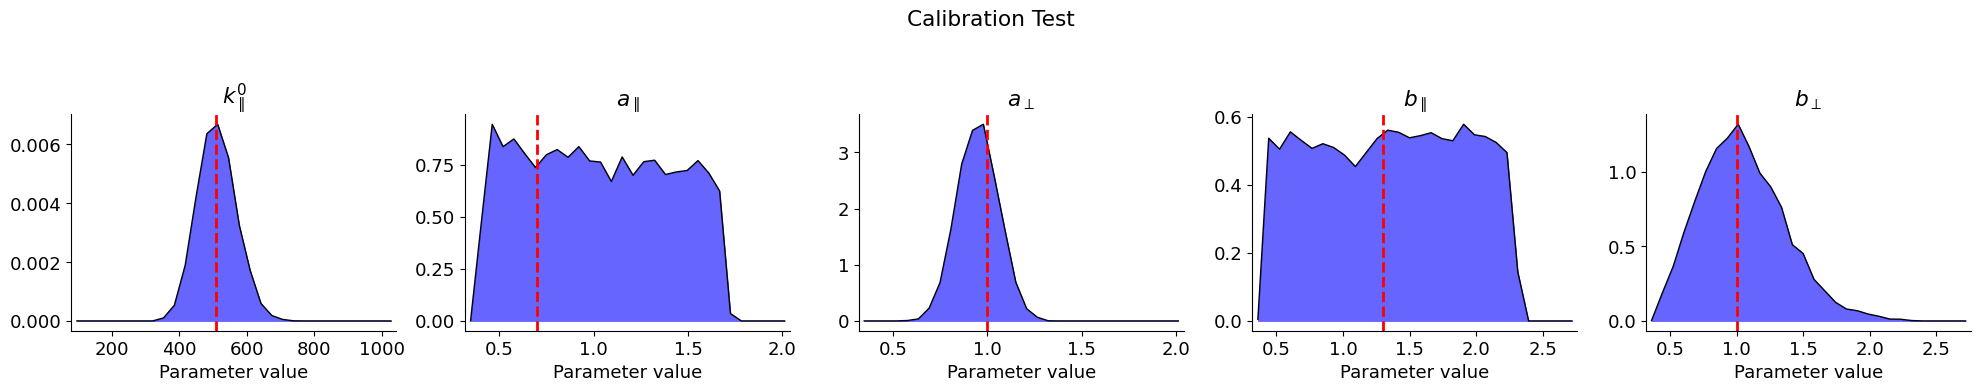

In [16]:
num_bins = 30
scale = True

fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=False)
plt.suptitle(
    f"Calibration Test"
)

for j, param in enumerate(PARAMETERS):
    # Common bins for this parameter (global binning)
    vmin = PARAMETERS_MIN[j] - 0.2 * PARAMETERS_MIN[j]
    vmax = PARAMETERS_MAX[j] + 0.2 * PARAMETERS_MAX[j]
    bins = np.linspace(vmin, vmax, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    ax = axs[j]
    
    ax.set_title(f"{PARAMETERS_NAME[j]}")

    max_hist = 0
    
    # Get maximum histogram value across all chains for this parameter
    samples = hmc_samples[param].values

    hist, _ = np.histogram(samples, bins=bins, density=True)

    # Filled area
    ax.fill_between(
        bin_centers,
        0,
        hist,
        alpha=0.6,
        linewidth=0.5,
        edgecolor="black",
        color='blue',
    )
    # Outline
    ax.plot(bin_centers, hist, linewidth=1.0, color="black")
    
    ax.set_xlim(vmin, vmax)
    ax.set_xlabel("Parameter value")
    
    # Clean up spines for a more "joyplot" aesthetic
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.axvline(
        true_parameter_values[j],
        color='red',
        lw=2,
        linestyle='--',
        label='True value'
    )

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(plots_dir / f'calibration_histogram_{idx}.png', dpi=300)
plt.savefig(plots_dir / f'calibration_histogram_{idx}.pdf')
plt.show()

## Individual run: change variations

In [17]:
data_version=['d1', 'd2', 'd3', 'd4', 'd5'] 
model_version=['init1', 'init2', 'init3', 'init4', 'init5'] 
hmc_run = ['hmc1', 'hmc2', 'hmc3', 'hmc4', 'hmc5']
bootstrap=['b0', 'b1'] # 'b0' or 'b1', false or true

# Parameters (change me!)
valid_idx = 2 
valid_interval_indices = [2, 79, 87, 103, 104, 128, 129, 146, 170, 175, 212, 235, 263, 311, 312, 337, 346, 358, 373, 403, 423, 434, 481, 484, 496, 519, 526, 528, 531, 549, 569, 579, 613, 616, 627, 645, 660, 668, 699, 707, 715, 739, 746, 777, 810, 859, 869, 917, 953, 1003, 1023, 1054, 1063, 1093, 1116, 1140, 1141, 1161, 1206, 1218, 1238, 1249, 1267, 1273, 1277, 1279, 1311, 1315, 1349, 1354, 1375, 1394, 1407, 1414, 1432, 1464, 1475, 1477, 1540, 1551, 1589, 1648, 1695, 1761, 1776, 1781, 1846, 1908, 1914, 1949, 1981, 1998, 2035, 2042, 2056, 2127, 2145, 2160, 2188, 2194]
idx = valid_interval_indices[valid_idx]

which_change_idx = 1
which_change = "no_bootstrap" #which_changes[which_change_idx] # 'bootstrapped_data', 'model_init', 'hmc_init'
train_size_fraction = 1.0
hmc_version='v34_trial5_ppc_10000_interpolated_test_pamela_sampled_False'
if which_change == "bootstrapped_data":
    data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_2 = f"{data_version[2]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_3 = f"{data_version[3]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_4 = f"{data_version[4]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
elif which_change == "model_init":
    data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[2]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[3]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[4]}_{hmc_run[0]}"
elif which_change == "hmc_init":
    data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[1]}"
    data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[2]}"
    data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[3]}"
    data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[4]}"
else: # Change me manually!
    data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[0]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[0]}_{model_version[1]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[0]}_{model_version[2]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[0]}_{model_version[3]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[0]}_{model_version[4]}_{hmc_run[0]}"


# Load relevant HMC results
results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"
results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}/"
results_dir_hmc_3 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{train_size_fraction}/"
results_dir_hmc_4 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_4}_{train_size_fraction}/"

# Make plots folder if it doesn't exist
plots_dir = Path(f'../../../results/{hmc_version}/plots/{which_change}/{train_size_fraction}/')
plots_dir.mkdir(parents=True, exist_ok=True)

# Get interval corresponding to one in paper
# Initialize exp_name, interval, and polarity for test data
df = pd.DataFrame({
    'experiment_name': ['test_neg'],
    'interval': ['test_neg'],
    'polarity': ['neg']
})
df_int = df.iloc[0]
interval = df_int.interval
polarity = df_int.polarity
exp_name = df_int.experiment_name
print(f"Interval {interval} corresponds to index {idx} for {polarity} polarity in {exp_name}.")
df_int.head()

# Load the samples from each hmc run
# They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
# csv file has no headers, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_2_samples = pd.read_csv(f'{results_dir_hmc_2}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_3_samples = pd.read_csv(f'{results_dir_hmc_3}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_4_samples = pd.read_csv(f'{results_dir_hmc_4}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

PARAMETERS = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples.columns = PARAMETERS
hmc_1_samples.columns = PARAMETERS
hmc_2_samples.columns = PARAMETERS
hmc_3_samples.columns = PARAMETERS
hmc_4_samples.columns = PARAMETERS

# Load x_test true parameter value for that index
# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
# features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
h5_file = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/test.h5'

# Load test data
with h5py.File(h5_file, 'r') as h5:
    num_test_samples, num_inputs,  = h5['X_minmax'].shape
    _, num_flux,  = h5['Y_log_scaled'].shape
x_test = h5py.File(h5_file, 'r')['X_minmax'][:].reshape(num_test_samples, num_inputs)

# Hardcoded model choices.
# INPUTS = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
# HMS Output order = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr'] (like NN inputs order)
# PARAMETERS = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr'] 
# PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
# PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 
x_test = x_test[idx, :]
sampled_parameters = x_test[2:7]
true_parameter_values = untransform_input(sampled_parameters)

print(f'x_test shape: {x_test.shape}\n and values: {x_test}, \nand sampled parameters: {sampled_parameters}')
print(f'sampled parameters for index {idx}: {true_parameter_values}')

# Calculate Gelman-Rubin R-hat statistic for each parameter
chains_samples = [hmc_0_samples, hmc_1_samples , hmc_2_samples, hmc_3_samples, hmc_4_samples]
rhats = compute_rhat(chains_samples, params=PARAMETERS, mode='split', thin=1, return_details=True)
print(rhats)
print("R-hat statistics:")
for param, rhat in rhats.items():
    if isinstance(rhat, tuple):
        rhat_value, details = rhat
        print(f"  {param}: {rhat_value:.4f} (details: m={details['m']}, n={details['n']}, rhat_classic={details['rhat_classic_equivalent']:.4f})")
    else:
        print(f"  {param}: {rhat:.4f}")

Interval test_neg corresponds to index 87 for neg polarity in test_neg.
x_test shape: (8,)
 and values: [0.47058824 0.5714286  0.53246754 0.2307692  0.46153846 0.4736842
 0.3157895  0.6666667 ], 
and sampled parameters: [0.53246754 0.2307692  0.46153846 0.4736842  0.3157895 ]
sampled parameters for index 87: [510.00000894   0.69999996   1.           1.29999996   1.00000003]
{'cpa': (1.0003440118945455, {'m': 10, 'n': 4939, 'theta_bar_j': array([513.10958387, 509.95491846, 508.74656874, 508.20509203,
       512.2777753 , 509.16522751, 508.28974269, 510.16800752,
       511.1402208 , 511.06046759]), 'sigma2_theta_j': array([3308.24766222, 3216.43325759, 3057.95616652, 3126.68014146,
       3132.17180453, 3402.98792788, 2993.71608642, 3315.71445236,
       3035.86521434, 2947.72085229]), 'theta_barbar': 510.21176045138384, 'sigma2_bar_theta': 3153.7493565624495, 'sigma2_theta_bar': 2.8087678700838175, 'B_j': 2.170227810038778, 'W': 3153.7493565624495, 'B': 13872.504510343975, 'var_plus': 

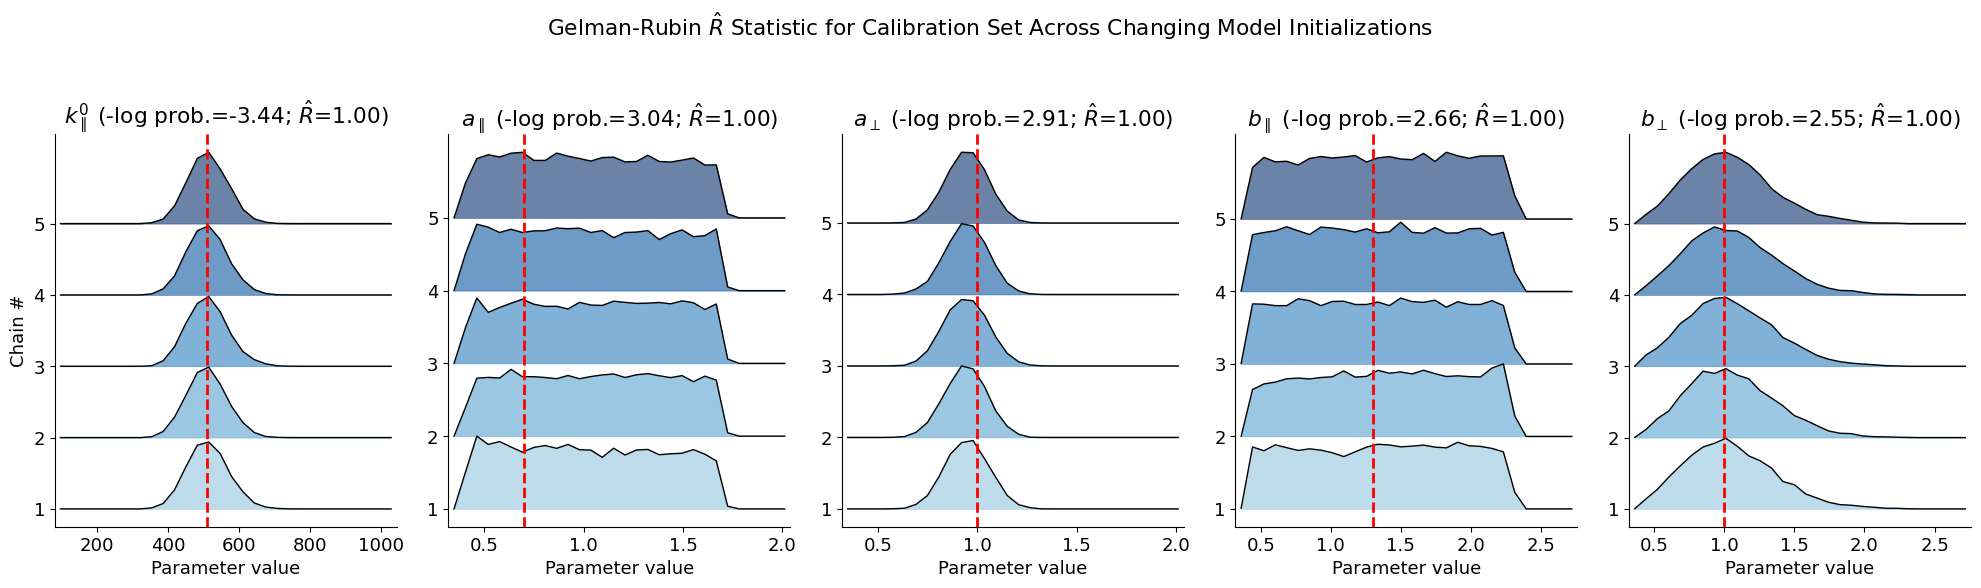

In [18]:
num_bins = 30
num_chains = 5
scale = True

chains = [hmc_0_samples, hmc_1_samples, hmc_2_samples, hmc_3_samples, hmc_4_samples]
chain_labels = ["1", "2", "3", "4", "5"]
colors = plt.cm.Blues(np.linspace(0.4, 1.0, num_chains))
param_hist_max = [1.0, 0.04, 0.25, 0.05, 0.25]

fig, axs = plt.subplots(1, 5, figsize=(20, 6), sharey=False)
plt.suptitle(
    r"Gelman-Rubin $\hat{R}$ Statistic for Calibration Set "
    + f"Across Changing Model Initializations"
)

for j, param in enumerate(PARAMETERS):
    # Common bins for this parameter (global binning)
    vmin = PARAMETERS_MIN[j] - 0.2 * PARAMETERS_MIN[j]
    vmax = PARAMETERS_MAX[j] + 0.2 * PARAMETERS_MAX[j]
    bins = np.linspace(vmin, vmax, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    ax = axs[j]
    max_hist = 0
    log_prob_true_param = []
    
    # Get maximum histogram value across all chains for this parameter
    for k, (chain, label, color) in list(enumerate(zip(chains, chain_labels, colors))):
        samples = chain[param].values

        hist, _ = np.histogram(samples, bins=bins, density=True)

        # Find maximum value of hist for each parameter across all chains
        if hist.max() > max_hist:
            max_hist = hist.max()

    # Ridgeline: each chain is one "ridge" offset in y
    for k, (chain, label, color) in list(enumerate(zip(chains, chain_labels, colors))):
        samples = chain[param].values

        hist, bin_edges = np.histogram(samples, bins=bins, density=True)

        # Optionally rescale each ridge to similar height for aesthetics
        if scale:
            if hist.max() > 0:
                hist = hist / max_hist
        
        offset = k  # vertical offset for this chain
        
        # Filled area
        ax.fill_between(
            bin_centers,
            offset,
            hist + offset,
            alpha=0.6,
            linewidth=0.5,
            edgecolor="black",
            color=color,
        )

        # Outline
        ax.plot(bin_centers, hist + offset, linewidth=1.0, color="black")

        # Calulcate the log probability of the true parameter value under this chain's histogram
        log_prob_true_param.append(histogram_log_prob(true_parameter_values[j], hist, bin_edges))

    # Plot true parameter value line
    ax.axvline(
        true_parameter_values[j],
        color='red',
        lw=2,
        linestyle='--',
        label='True value'
    )

    avg_log_prob = np.mean(log_prob_true_param)
    ax.set_title(f"{PARAMETERS_NAME[j]} " +  f"(-log prob.={-1 * avg_log_prob:.2f}; " + r"$\hat{R}$=" + f"{rhats[param][0]:.2f})")
    
    ax.set_xlim(vmin, vmax)
    ax.set_yticks(range(num_chains))
    ax.set_yticklabels(chain_labels)
    ax.set_xlabel("Parameter value")
    if j == 0:
        ax.set_ylabel("Chain #")
    
    # Clean up spines for a more "joyplot" aesthetic
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(plots_dir / f'calibration_histogram_{idx}.png', dpi=300)
plt.savefig(plots_dir / f'calibration_histogram_{idx}.pdf')
plt.show()
